<a href="https://colab.research.google.com/github/Juan-Garassino/bitcoin-time-series/blob/master/bitcoin-time-series-new-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [329]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [330]:
!pip install pmdarima

!pip install statsmodels

In [331]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

plt.style.available
plt.style.use('seaborn-whitegrid')

STYLE = "#ffffff"

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm

# CSV

## Bitcoin

In [332]:
FREQ = 73 # BEST = 145
LAGS_BIAS = 0.3
TRAIN_SIZE = 0.75

In [333]:
"""
Alias    Description
B        business day frequency
C        custom business day frequency
D        calendar day frequency
W        weekly frequency
M        month end frequency
SM       semi-month end frequency (15th and end of month)
BM       business month end frequency
CBM      custom business month end frequency
MS       month start frequency
SMS      semi-month start frequency (1st and 15th)
BMS      business month start frequency
CBMS     custom business month start frequency
Q        quarter end frequency
BQ       business quarter end frequency
QS       quarter start frequency
BQS      business quarter start frequency
A, Y     year end frequency
BA, BY   business year end frequency
AS, YS   year start frequency
BAS, BYS business year start frequency
BH       business hour frequency
H        hourly frequency
T, min   minutely frequency
S        secondly frequency
L, ms    milliseconds
U, us    microseconds
N        nanoseconds
"""

'\nAlias    Description\nB        business day frequency\nC        custom business day frequency\nD        calendar day frequency\nW        weekly frequency\nM        month end frequency\nSM       semi-month end frequency (15th and end of month)\nBM       business month end frequency\nCBM      custom business month end frequency\nMS       month start frequency\nSMS      semi-month start frequency (1st and 15th)\nBMS      business month start frequency\nCBMS     custom business month start frequency\nQ        quarter end frequency\nBQ       business quarter end frequency\nQS       quarter start frequency\nBQS      business quarter start frequency\nA, Y     year end frequency\nBA, BY   business year end frequency\nAS, YS   year start frequency\nBAS, BYS business year start frequency\nBH       business hour frequency\nH        hourly frequency\nT, min   minutely frequency\nS        secondly frequency\nL, ms    milliseconds\nU, us    microseconds\nN        nanoseconds\n'

In [334]:
def load_data():
    Market_Price = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-Market-price.csv")
    Market_Cap = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-Market-cap.csv")
    Trade_Volume = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-Trade-volume.csv")
    Total_Circulation = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-Circ-total.csv")
    MVRV = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-mvrv.csv")
    NVT = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-nvt.csv")
    NVTS = pd.read_csv("/content/drive/MyDrive/Data/Bitcoin/Bitcoin-nvts.csv")


    return [Market_Price, Market_Cap, Trade_Volume, Total_Circulation, MVRV, NVT, NVTS]

def datetimes(data):
  for x in range(0, len(data)):
    data[x].iloc[:,0] = pd.to_datetime(data[x].iloc[:,0])
    data[x] = data[x].set_index("Timestamp")
    data[x] = data[x].resample("SMS").mean().interpolate()

In [335]:
bitcoin = load_data()

datetimes(bitcoin)

bitcoin = pd.concat([bitcoin[0],
                     bitcoin[1],
                     bitcoin[2],
                     bitcoin[3],
                     bitcoin[4],
                     bitcoin[5],
                     bitcoin[6]], axis = 1).dropna()

bitcoin["Bitcoin Logarithm"] = np.log(bitcoin['market-price'])

bitcoin["trade-volume"] = bitcoin["trade-volume"].clip(lower = 0.0001)

bitcoin

,market-price,market-cap,trade-volume,total-bitcoins,mvrv,nvt,nvts,Bitcoin Logarithm
Timestamp,,,,,,,,
2010-10-01,0.080000,3.365438e+05,1.000000e-04,4.199170e+06,6.267194,35.966684,180.991766,-2.525729
2010-10-15,0.148333,6.210580e+05,1.000000e-04,4.352717e+06,5.542313,37.530723,110.523846,-1.908293
2010-11-01,0.265000,1.386411e+06,1.000000e-04,4.517217e+06,5.693194,80.765412,114.487862,-1.328025
2010-11-15,0.288333,1.338049e+06,1.000000e-04,4.660200e+06,3.752774,78.260726,73.034336,-1.243638
2010-12-01,0.240000,1.168440e+06,1.000000e-04,4.803167e+06,2.968393,68.464715,56.586210,-1.427116
...,...,...,...,...,...,...,...,...
2020-11-15,17755.550000,3.293683e+11,3.690036e+08,1.855085e+07,2.472003,8.853913,10.733026,9.784453
2020-12-01,19179.904000,3.506480e+11,3.026336e+08,1.856579e+07,2.480316,10.761146,10.803452,9.861618
2020-12-15,24025.786667,4.587012e+11,5.533578e+08,1.857938e+07,2.868237,9.651028,13.197545,10.086883


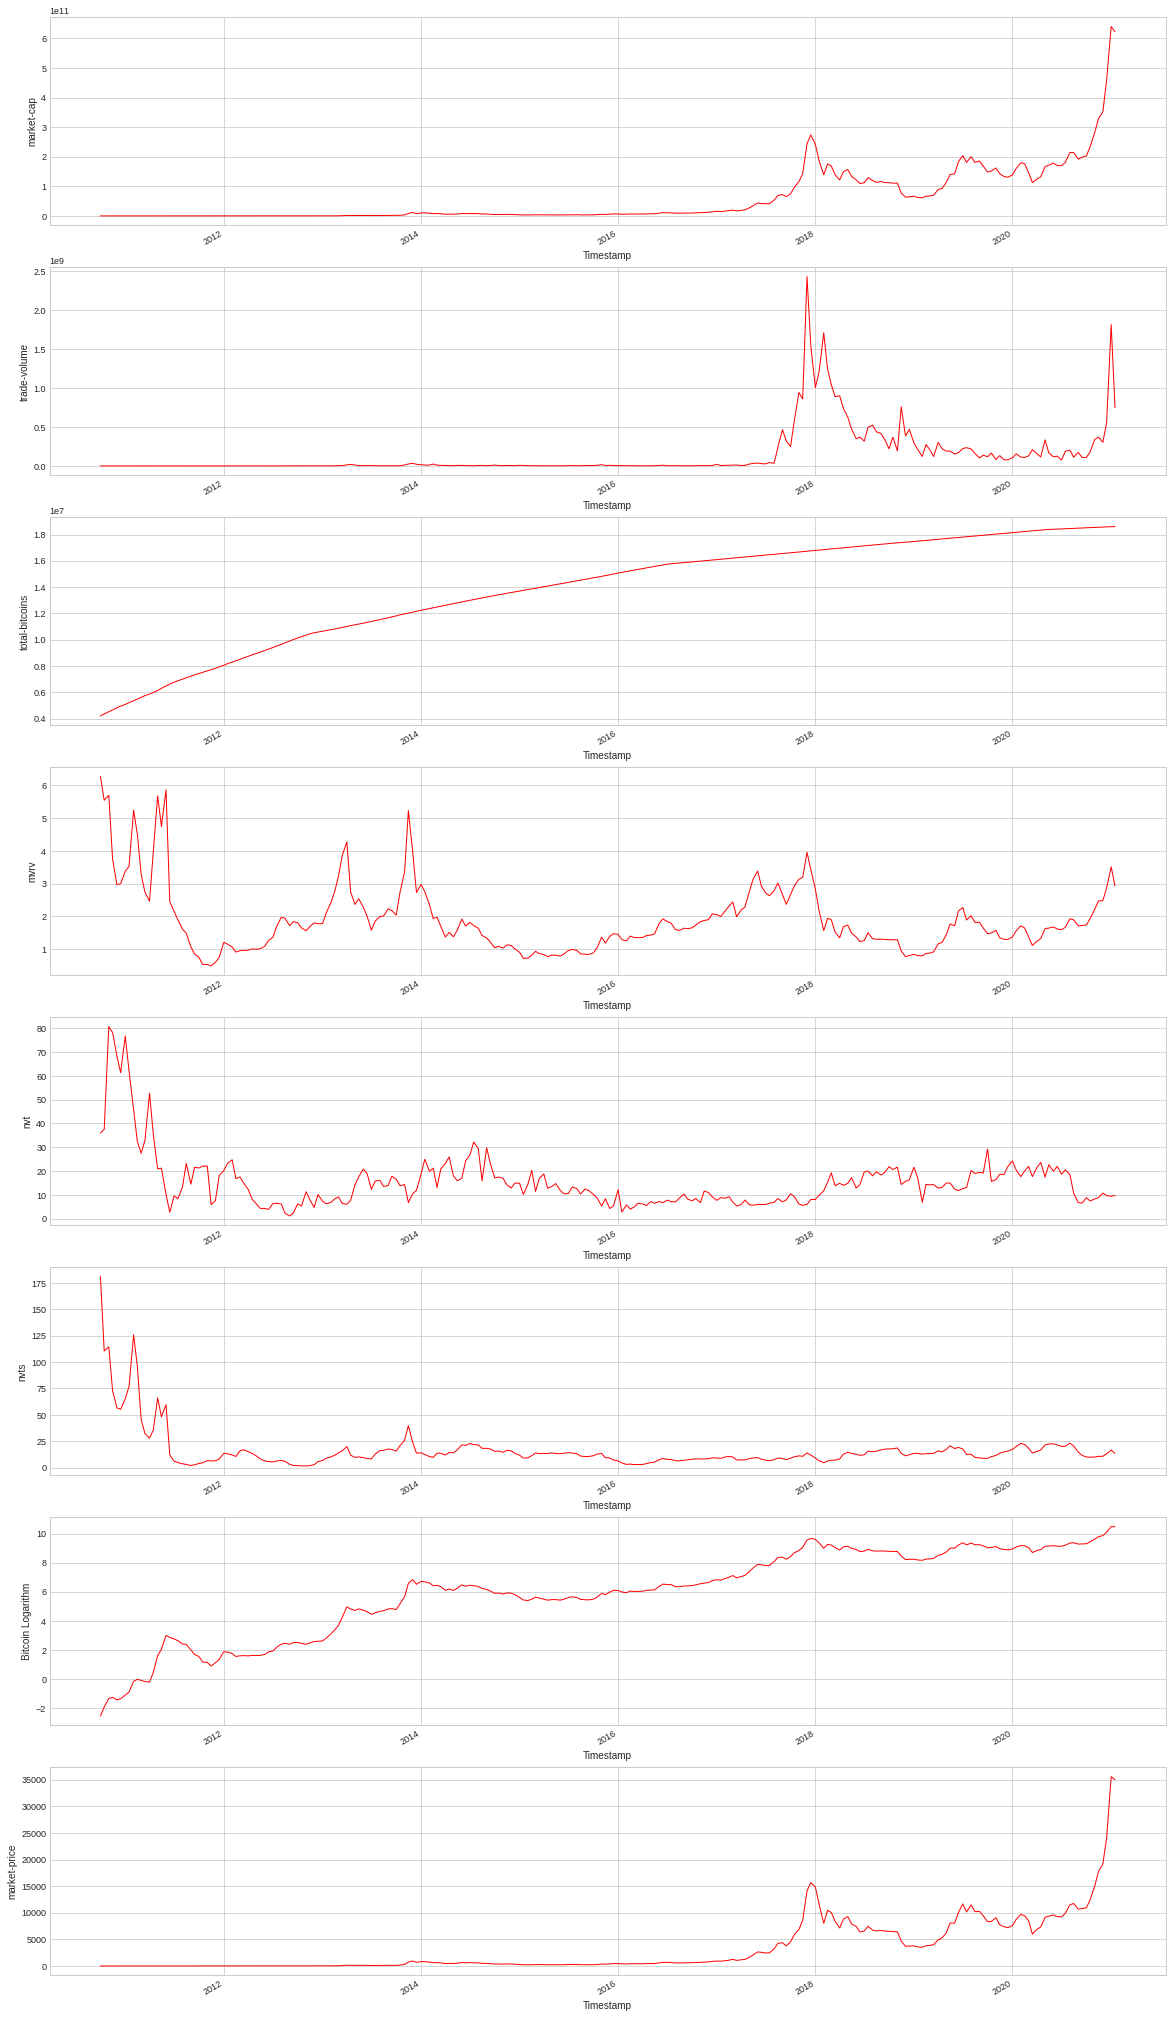

In [336]:
plt.rc('xtick',labelsize=9)
plt.rc('ytick',labelsize=9)

fig, ax = plt.subplots(len(bitcoin.columns),1, figsize=(20,40), facecolor = STYLE)

for x in range(0,len(bitcoin.columns)):
  bitcoin[f"{bitcoin.columns[x]}"].plot(ax=ax[x-1], c = "r", linewidth = 1)
  ax[x-1].set_ylabel(f"{bitcoin.columns[x]}")

## Seasonal Decomposition

In [337]:
mp_decomp_add = seasonal_decompose(bitcoin['market-price'], model="additive", period = FREQ)
mc_decomp_add = seasonal_decompose(bitcoin['market-cap'], model="additive", period = FREQ)
tv_decomp_add = seasonal_decompose(bitcoin['trade-volume'], model="additive", period = FREQ)
tb_decomp_add = seasonal_decompose(bitcoin['total-bitcoins'], model="additive", period = FREQ)
mrrv_decomp_add = seasonal_decompose(bitcoin['mvrv'], model="additive", period = FREQ)
nvt_decomp_add = seasonal_decompose(bitcoin['nvt'], model="additive", period = FREQ)
nvts_decomp_add = seasonal_decompose(bitcoin['nvts'], model="additive", period = FREQ)
bl_decomp_add = seasonal_decompose(bitcoin['Bitcoin Logarithm'], model="additive", period = FREQ)

Text(0, 0.5, 'Bitcoin Logarithm')

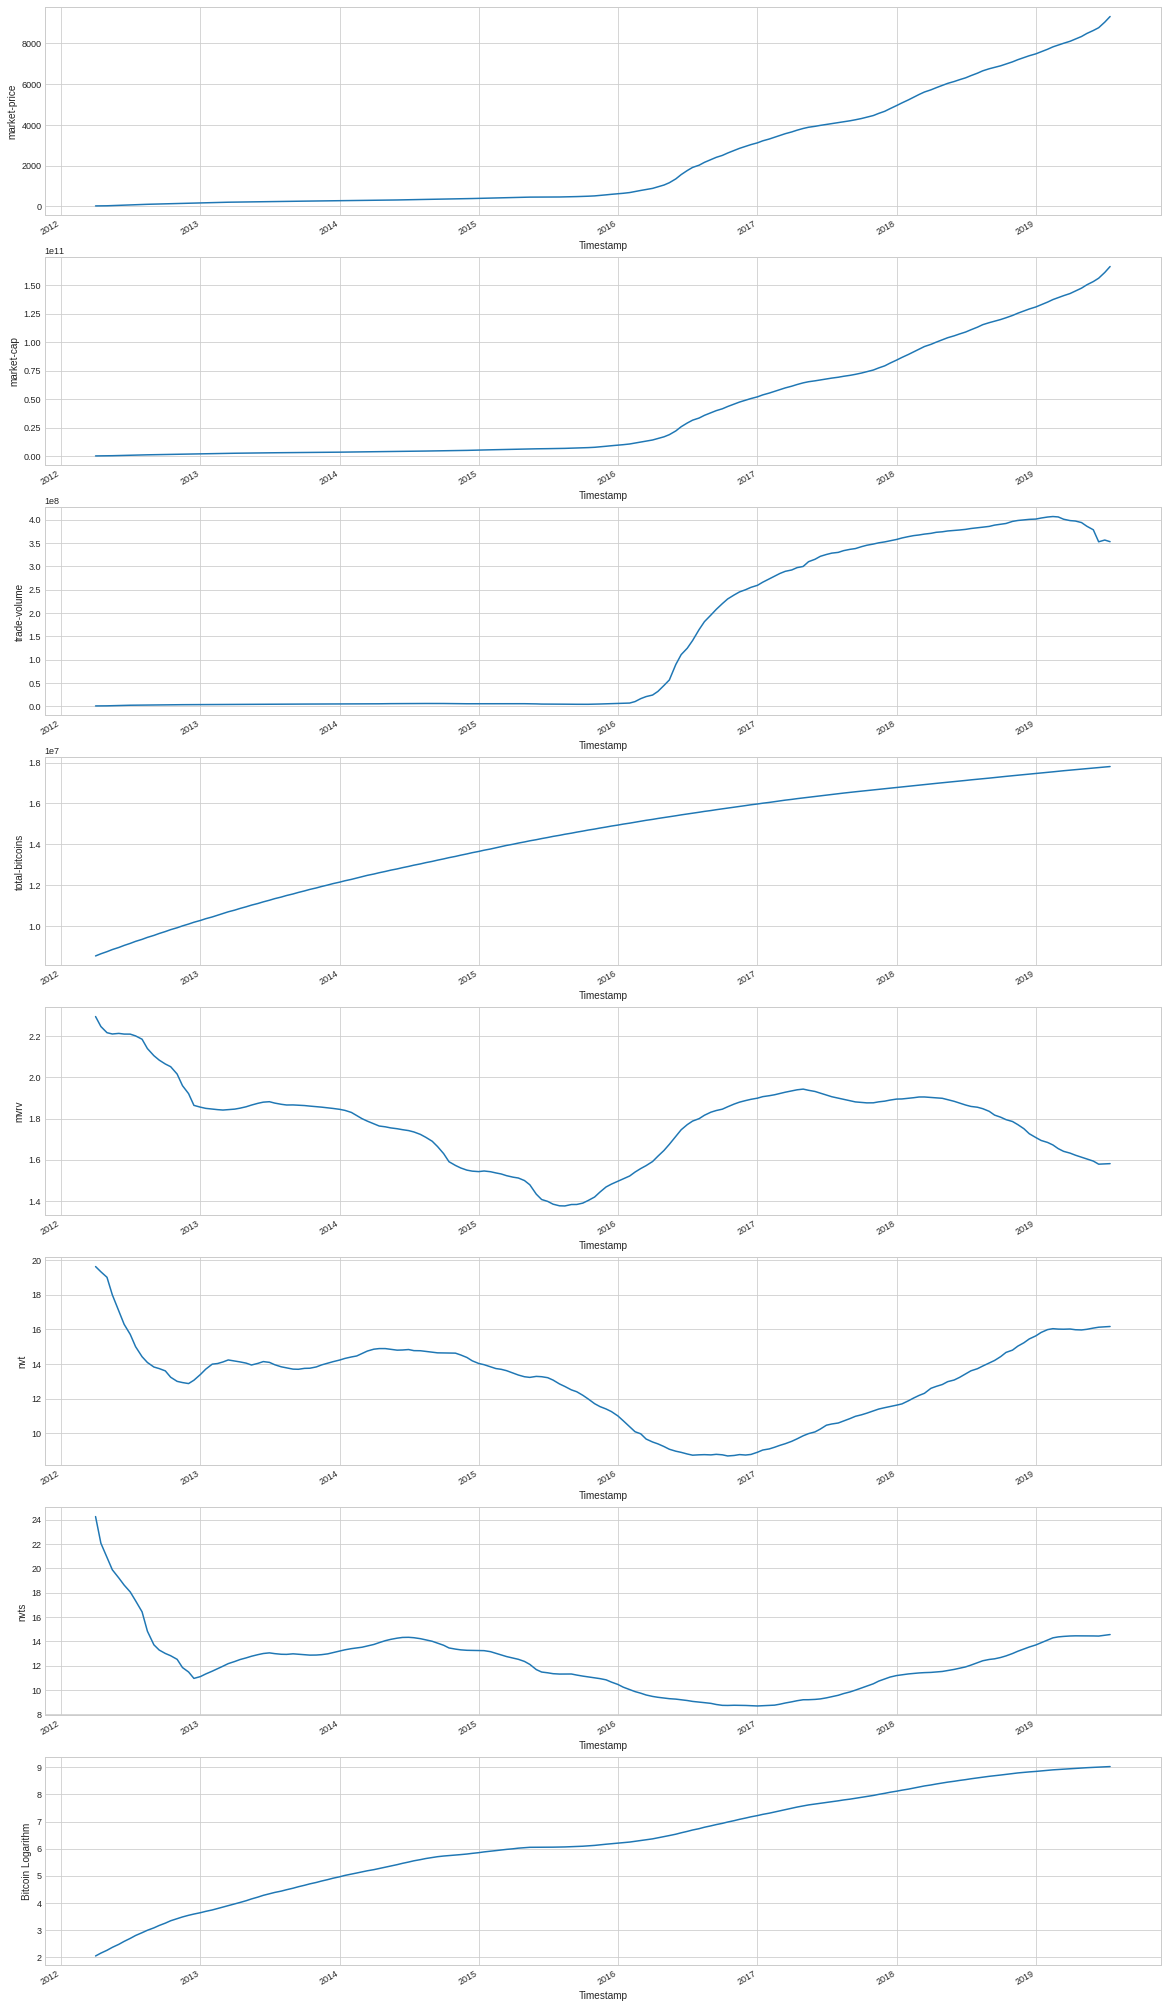

In [338]:
fig, ax = plt.subplots(len(bitcoin.columns),1, figsize=(20,40), facecolor = STYLE)

mp_decomp_add.trend.plot(ax=ax[0])
ax[0].set_ylabel('market-price')
mc_decomp_add.trend.plot(ax=ax[1])
ax[1].set_ylabel('market-cap')
tv_decomp_add.trend.plot(ax=ax[2])
ax[2].set_ylabel('trade-volume')
tb_decomp_add.trend.plot(ax=ax[3])
ax[3].set_ylabel('total-bitcoins')
mrrv_decomp_add.trend.plot(ax=ax[4])
ax[4].set_ylabel('mvrv')
nvt_decomp_add.trend.plot(ax=ax[5])
ax[5].set_ylabel('nvt')
nvts_decomp_add.trend.plot(ax=ax[6])
ax[6].set_ylabel('nvts')
bl_decomp_add.trend.plot(ax=ax[7])
ax[7].set_ylabel('Bitcoin Logarithm')

Text(0, 0.5, 'Bitcoin Logarithm')

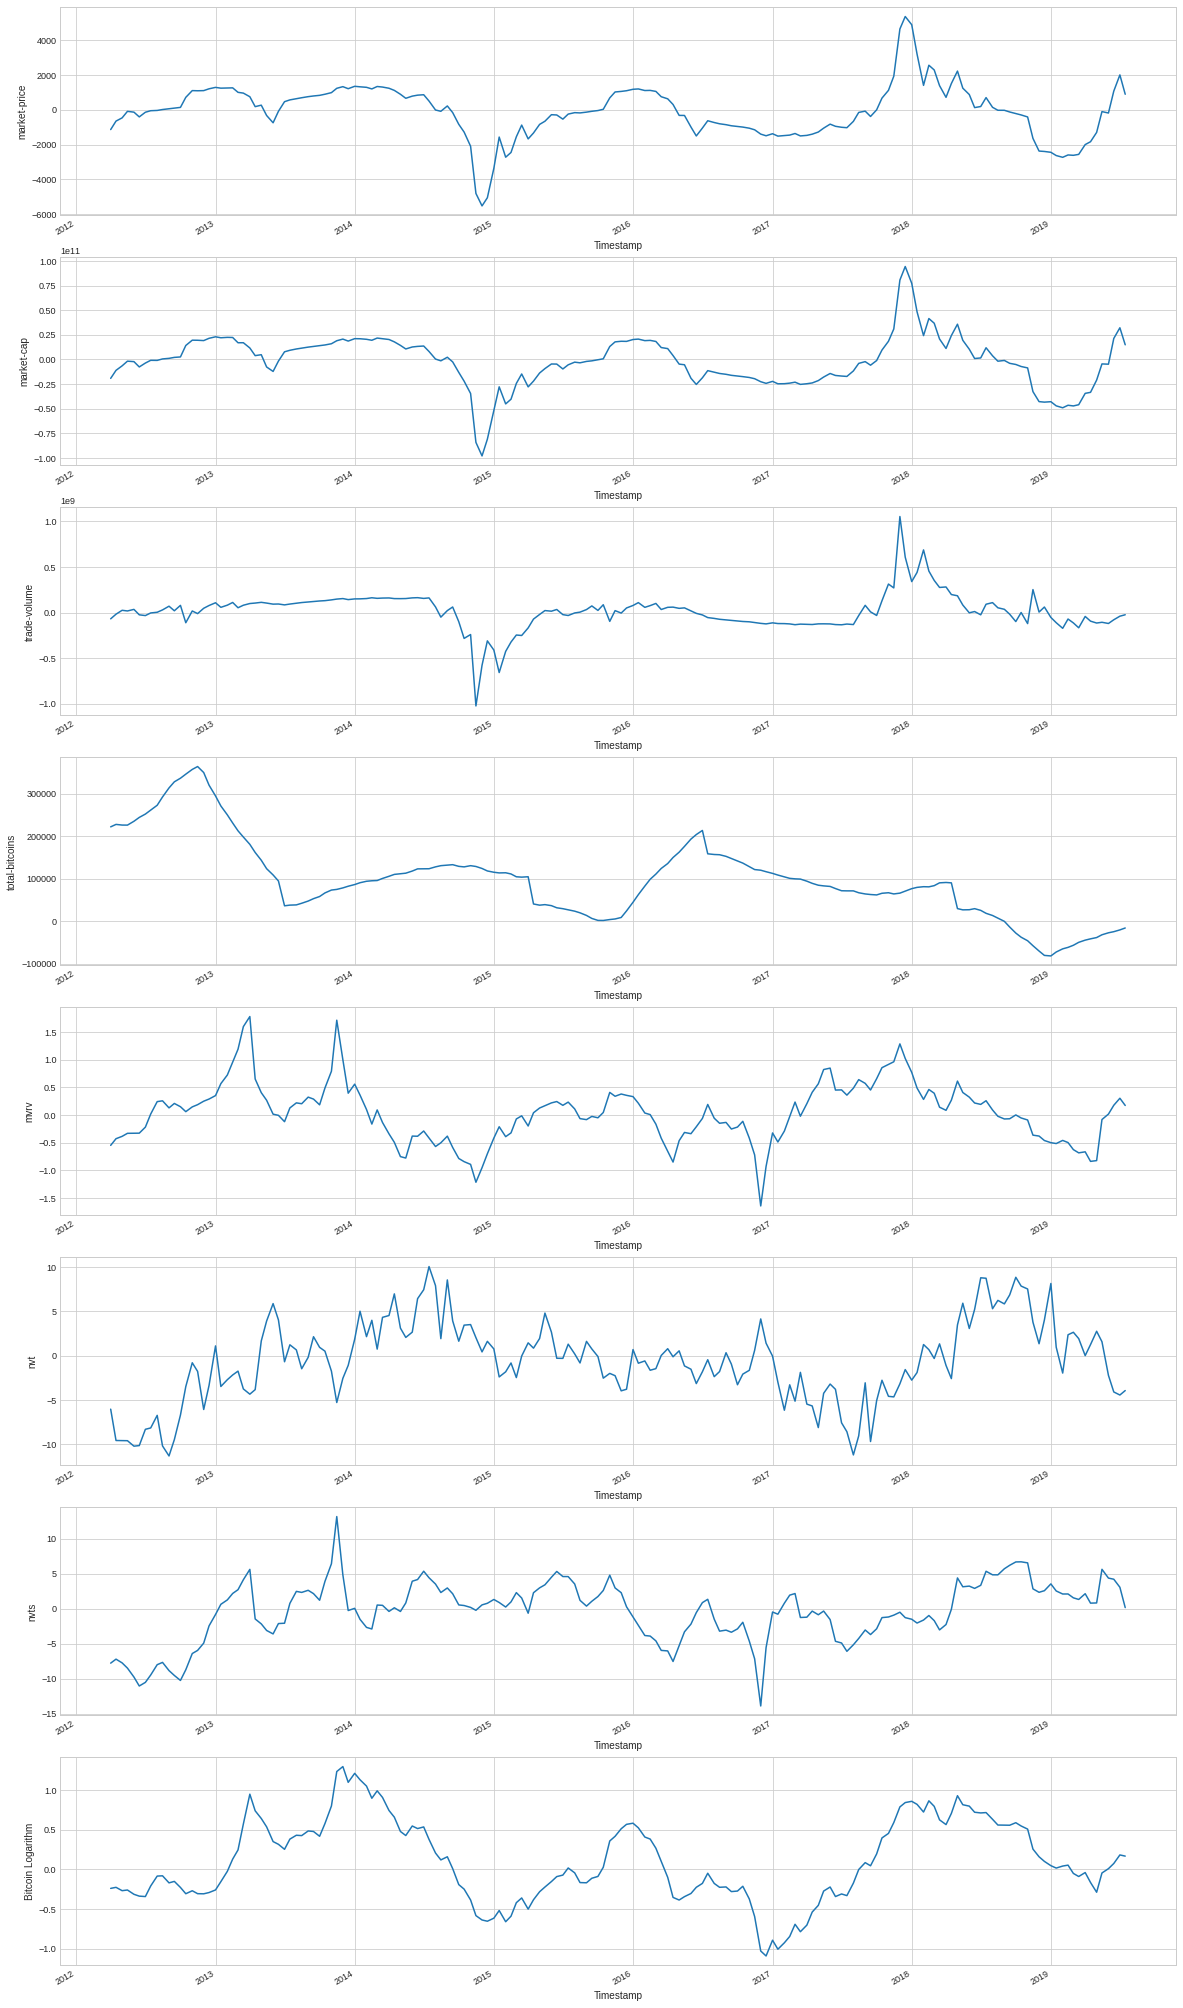

In [339]:
fig, ax = plt.subplots(len(bitcoin.columns),1, figsize=(20,40), facecolor = STYLE)

mp_decomp_add.resid.plot(ax=ax[0])
ax[0].set_ylabel('market-price')
mc_decomp_add.resid.plot(ax=ax[1])
ax[1].set_ylabel('market-cap')
tv_decomp_add.resid.plot(ax=ax[2])
ax[2].set_ylabel('trade-volume')
tb_decomp_add.resid.plot(ax=ax[3])
ax[3].set_ylabel('total-bitcoins')
mrrv_decomp_add.resid.plot(ax=ax[4])
ax[4].set_ylabel('mvrv')
nvt_decomp_add.resid.plot(ax=ax[5])
ax[5].set_ylabel('nvt')
nvts_decomp_add.resid.plot(ax=ax[6])
ax[6].set_ylabel('nvts')
bl_decomp_add.resid.plot(ax=ax[7])
ax[7].set_ylabel('Bitcoin Logarithm')

Text(0, 0.5, 'Bitcoin Logarithm')

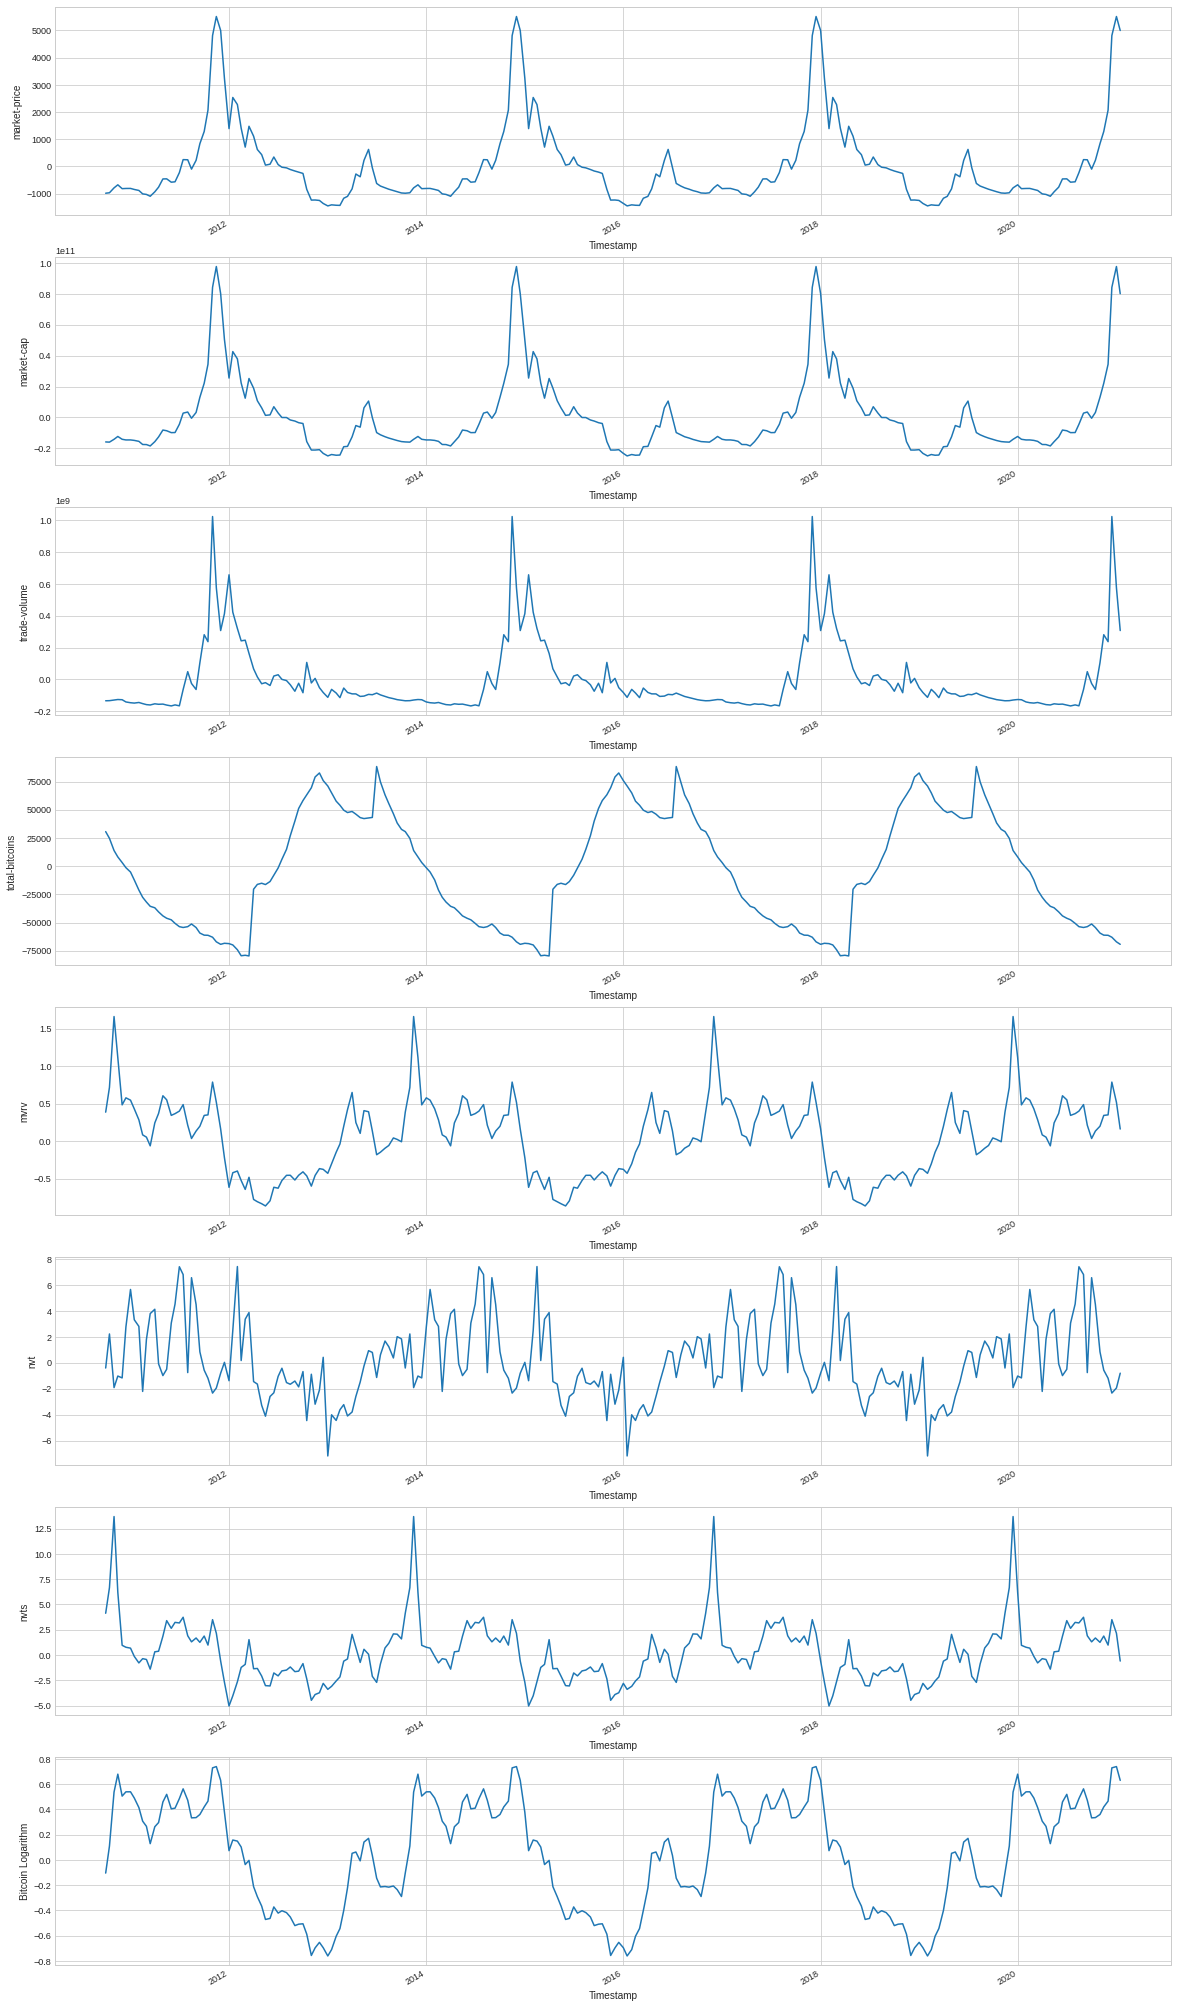

In [340]:
fig, ax = plt.subplots(len(bitcoin.columns),1, figsize=(20,40), facecolor = STYLE)

mp_decomp_add.seasonal.plot(ax=ax[0])
ax[0].set_ylabel('market-price')
mc_decomp_add.seasonal.plot(ax=ax[1])
ax[1].set_ylabel('market-cap')
tv_decomp_add.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('trade-volume')
tb_decomp_add.seasonal.plot(ax=ax[3])
ax[3].set_ylabel('total-bitcoins')
mrrv_decomp_add.seasonal.plot(ax=ax[4])
ax[4].set_ylabel('mvrv')
nvt_decomp_add.seasonal.plot(ax=ax[5])
ax[5].set_ylabel('nvt')
nvts_decomp_add.seasonal.plot(ax=ax[6])
ax[6].set_ylabel('nvts')
bl_decomp_add.seasonal.plot(ax=ax[7])
ax[7].set_ylabel('Bitcoin Logarithm')

In [341]:
mp_decomp_mul = seasonal_decompose(bitcoin['market-price'], model="multiplicative", period = FREQ)
mc_decomp_mul = seasonal_decompose(bitcoin['market-cap'], model="multiplicative", period = FREQ)
tv_decomp_mul = seasonal_decompose(bitcoin['trade-volume'], model="multiplicative", period = FREQ)
tb_decomp_mul = seasonal_decompose(bitcoin['total-bitcoins'], model="multiplicative", period = FREQ)
mrrv_decomp_mul = seasonal_decompose(bitcoin['mvrv'], model="multiplicative", period = FREQ)
nvt_decomp_mul = seasonal_decompose(bitcoin['nvt'], model="multiplicative", period = FREQ)
nvts_decomp_mul = seasonal_decompose(bitcoin['nvts'], model="multiplicative", period = FREQ)
# bl_decomp_mul = seasonal_decompose(bitcoin['Bitcoin Logarithm'], model="multiplicative", period = FREQ)

Text(0, 0.5, 'nvts')

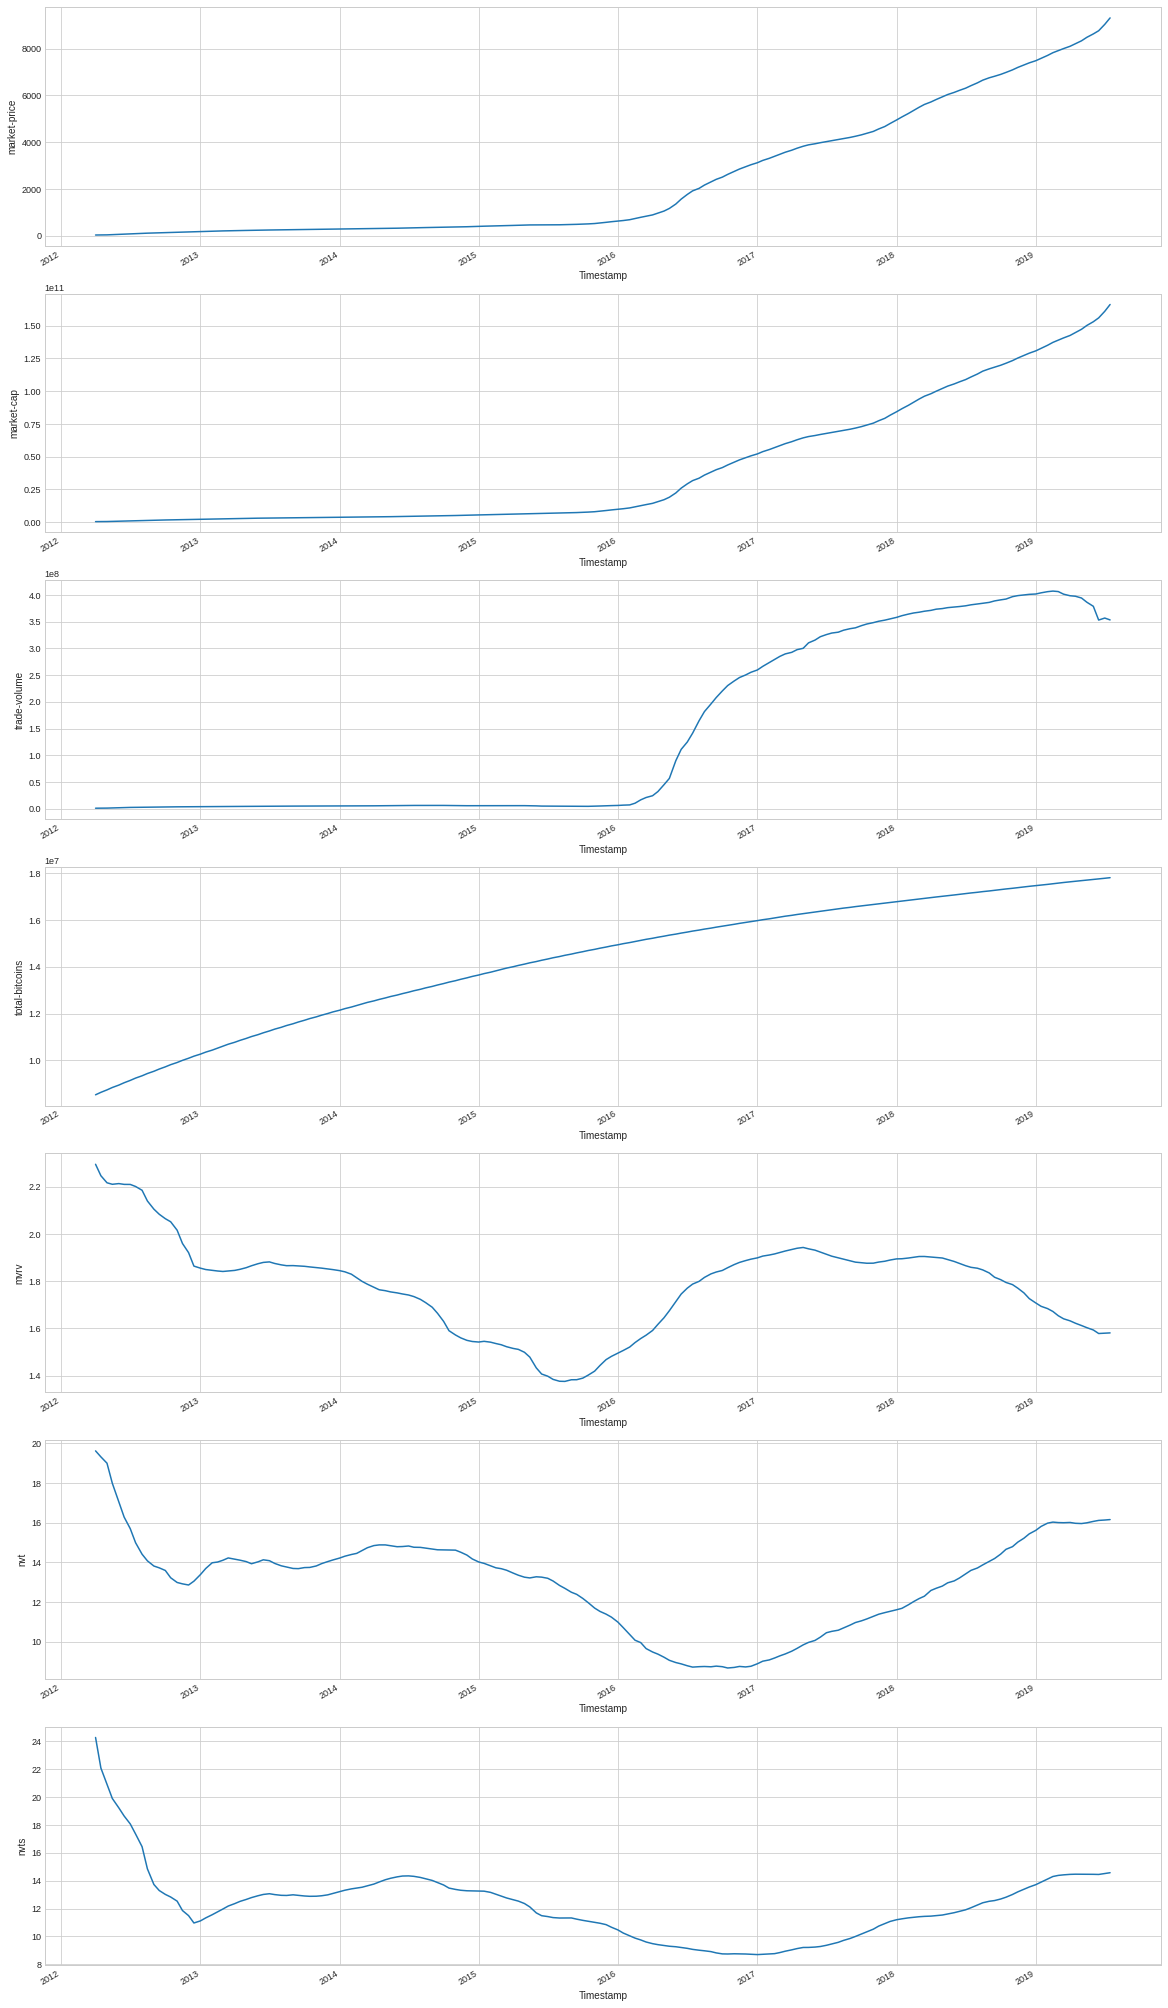

In [342]:
fig, ax = plt.subplots(len(bitcoin.columns)-1,1, figsize=(20,40), facecolor = STYLE)

mp_decomp_mul.trend.plot(ax=ax[0])
ax[0].set_ylabel('market-price')
mc_decomp_mul.trend.plot(ax=ax[1])
ax[1].set_ylabel('market-cap')
tv_decomp_mul.trend.plot(ax=ax[2])
ax[2].set_ylabel('trade-volume')
tb_decomp_mul.trend.plot(ax=ax[3])
ax[3].set_ylabel('total-bitcoins')
mrrv_decomp_mul.trend.plot(ax=ax[4])
ax[4].set_ylabel('mvrv')
nvt_decomp_mul.trend.plot(ax=ax[5])
ax[5].set_ylabel('nvt')
nvts_decomp_mul.trend.plot(ax=ax[6])
ax[6].set_ylabel('nvts')
# bl_decomp_mul.trend.plot(ax=ax[7])
# ax[7].set_ylabel('Bitcoin Logarithm')

Text(0, 0.5, 'nvts')

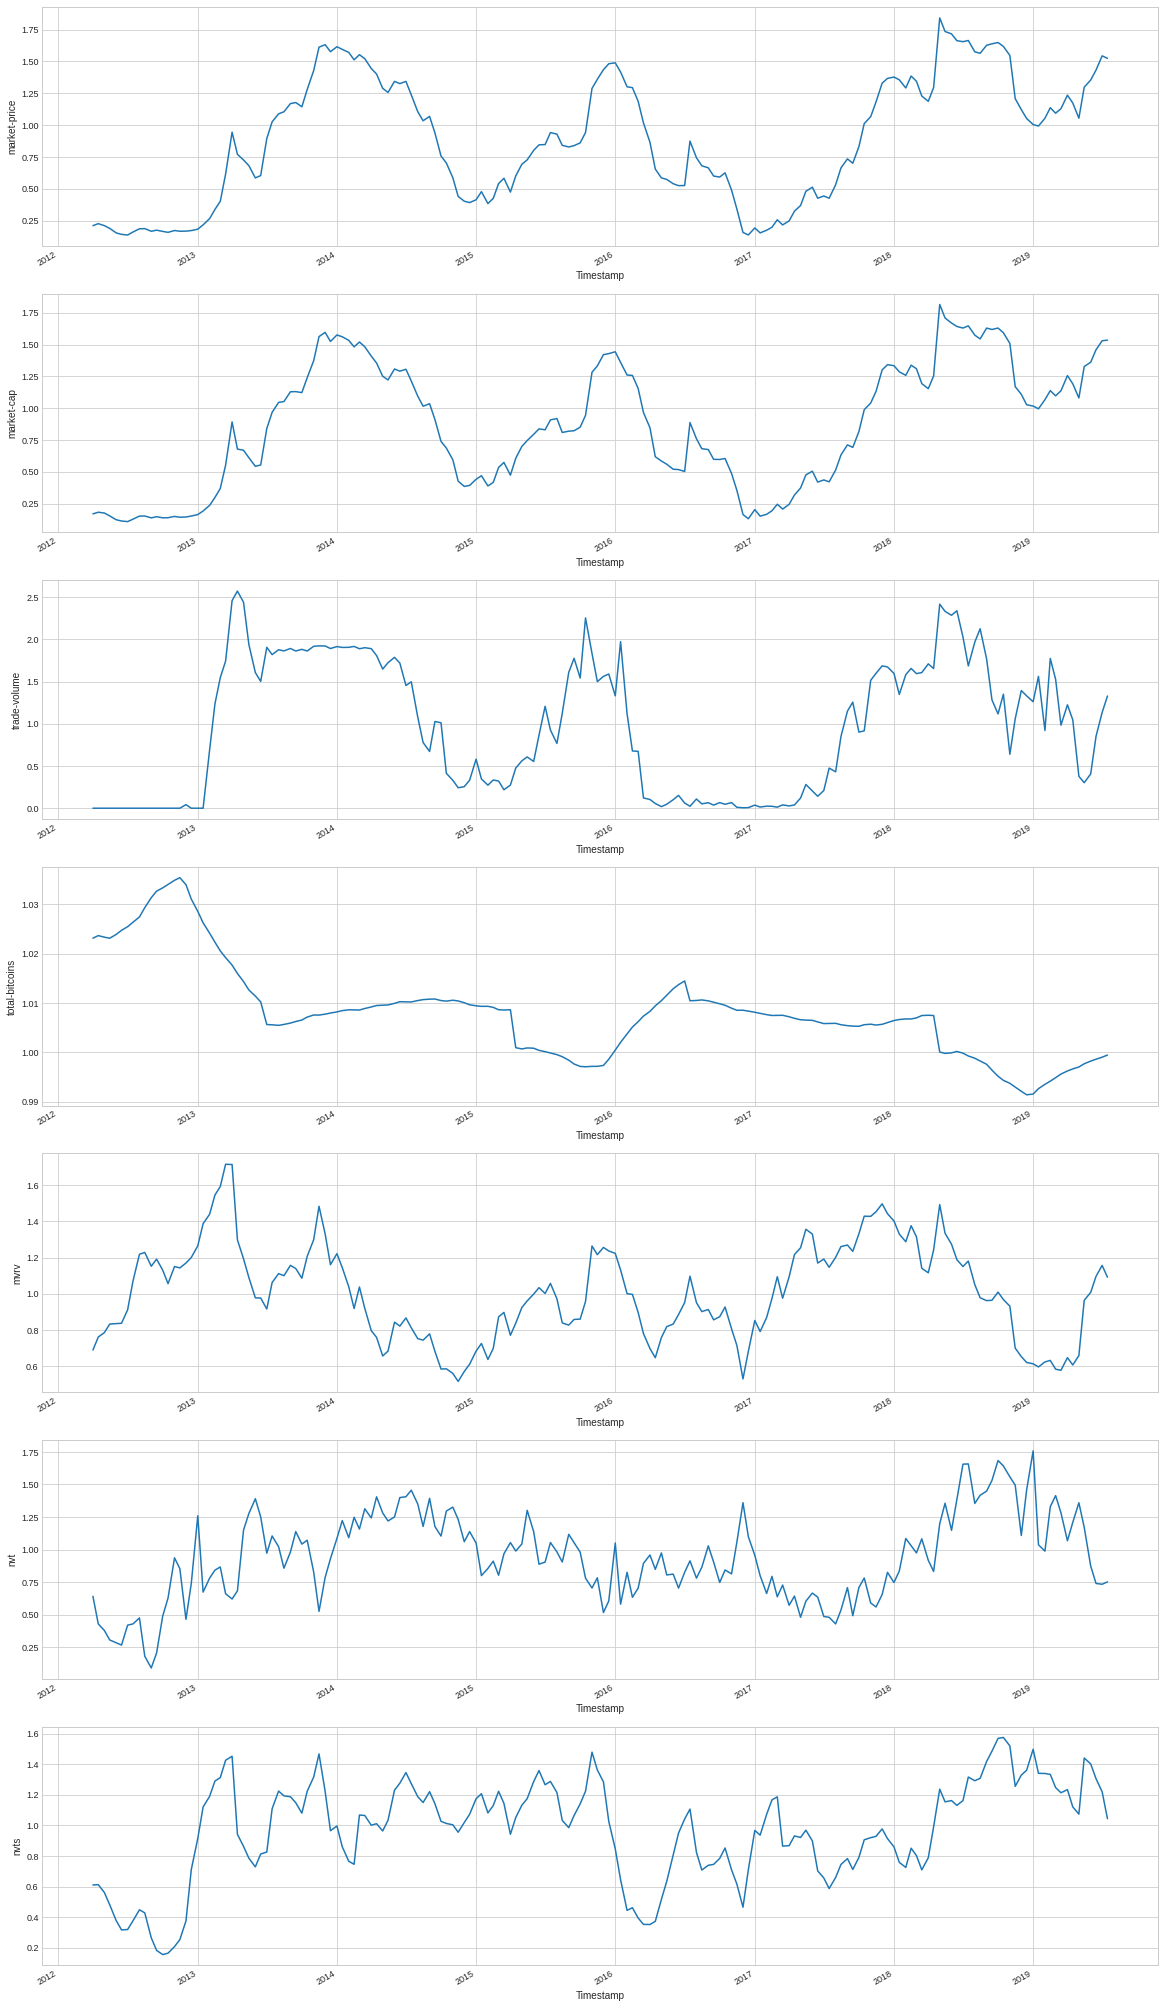

In [343]:
fig, ax = plt.subplots(len(bitcoin.columns)-1,1, figsize=(20,40), facecolor = STYLE)

mp_decomp_mul.resid.plot(ax=ax[0])
ax[0].set_ylabel('market-price')
mc_decomp_mul.resid.plot(ax=ax[1])
ax[1].set_ylabel('market-cap')
tv_decomp_mul.resid.plot(ax=ax[2])
ax[2].set_ylabel('trade-volume')
tb_decomp_mul.resid.plot(ax=ax[3])
ax[3].set_ylabel('total-bitcoins')
mrrv_decomp_mul.resid.plot(ax=ax[4])
ax[4].set_ylabel('mvrv')
nvt_decomp_mul.resid.plot(ax=ax[5])
ax[5].set_ylabel('nvt')
nvts_decomp_mul.resid.plot(ax=ax[6])
ax[6].set_ylabel('nvts')
# bl_decomp_mul.resid.plot(ax=ax[7])
# ax[7].set_ylabel('Bitcoin Logarithm')

Text(0, 0.5, 'nvts')

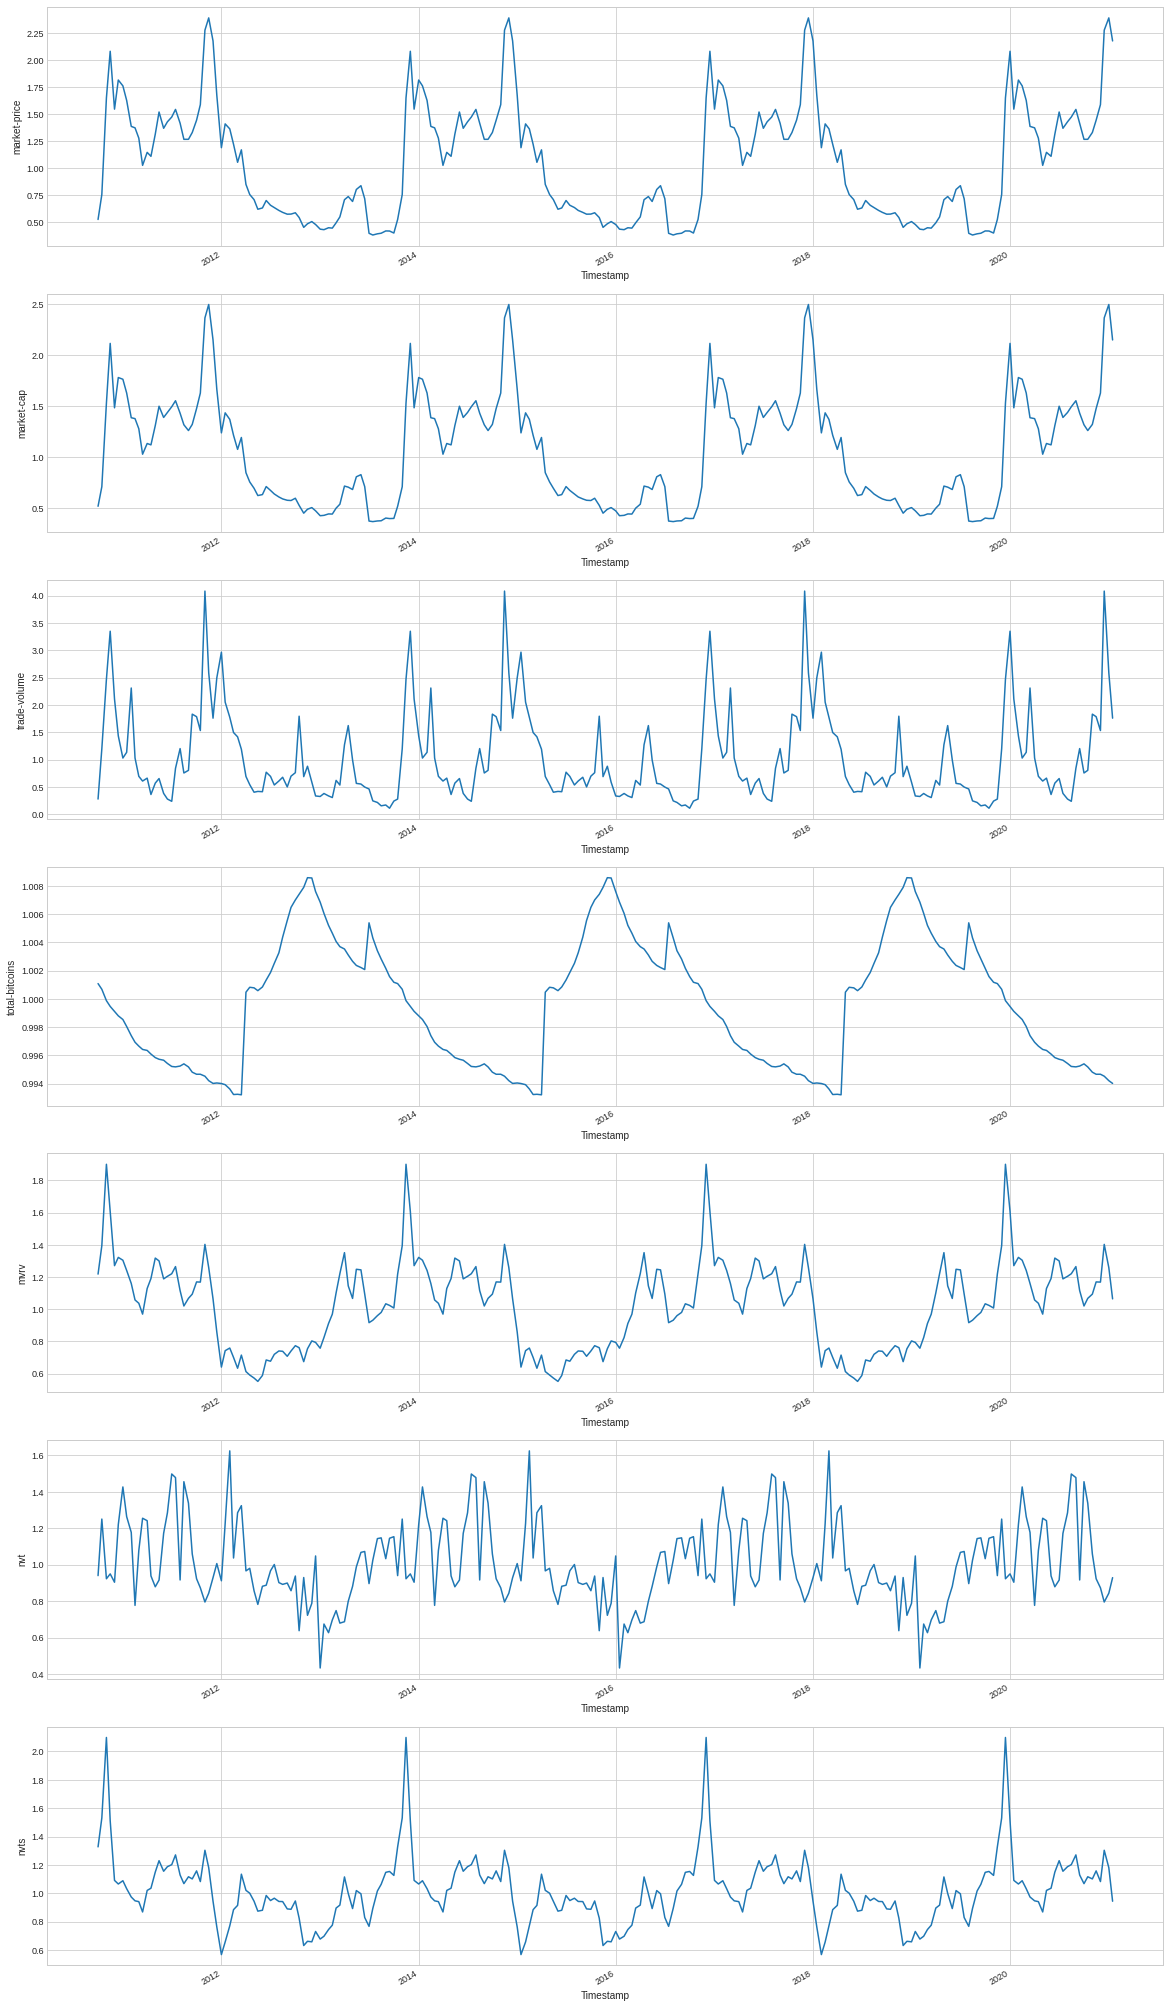

In [344]:
fig, ax = plt.subplots(len(bitcoin.columns)-1,1, figsize=(20,40), facecolor = STYLE)

mp_decomp_mul.seasonal.plot(ax=ax[0])
ax[0].set_ylabel('market-price')
mc_decomp_mul.seasonal.plot(ax=ax[1])
ax[1].set_ylabel('market-cap')
tv_decomp_mul.seasonal.plot(ax=ax[2])
ax[2].set_ylabel('trade-volume')
tb_decomp_mul.seasonal.plot(ax=ax[3])
ax[3].set_ylabel('total-bitcoins')
mrrv_decomp_mul.seasonal.plot(ax=ax[4])
ax[4].set_ylabel('mvrv')
nvt_decomp_mul.seasonal.plot(ax=ax[5])
ax[5].set_ylabel('nvt')
nvts_decomp_mul.seasonal.plot(ax=ax[6])
ax[6].set_ylabel('nvts')
# bl_decomp_mul.seasonal.plot(ax=ax[7])
# ax[7].set_ylabel('Bitcoin Logarithm')

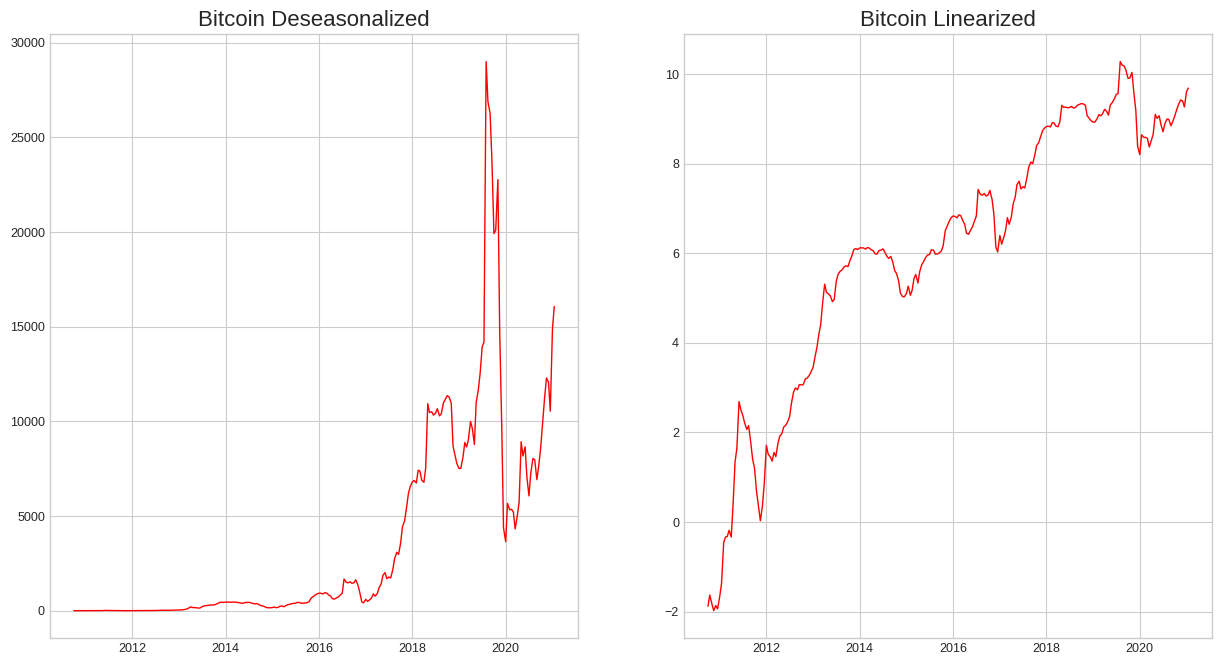

In [345]:
plt.rc('xtick',labelsize=9)
plt.rc('ytick',labelsize=9)

# Let's remove seasons
bitcoin['Deseasonalized'] = bitcoin['market-price'].values / decomp_mult.seasonal

plt.figure(figsize=(15, 8), dpi = 100, facecolor = (STYLE));
plt.subplot(1,2,1);
plt.plot(bitcoin["Deseasonalized"], c = "r", linewidth = 1);
plt.title('Bitcoin Deseasonalized', fontsize = 16);

# Also remove exponential trend 
bitcoin['Linearized'] = np.log(bitcoin['Deseasonalized'])

plt.subplot(1,2,2);
plt.plot(bitcoin['Linearized'], c = "r", linewidth = 1)
plt.title('Bitcoin Linearized', fontsize = 16);

In [346]:
# Otro DataFrame

difference = pd.DataFrame()

difference["Normal differencing"] = bitcoin["Linearized"].diff(1)
difference["Seasonal differencing"] = bitcoin["Linearized"].diff(FREQ)
difference["Sesonal + Normal differencing"] = bitcoin["Linearized"].diff(FREQ).diff(1)

difference = difference.dropna()

In [347]:
# with mpl.rc_context():
#     mpl.rc("figure", figsize=(12,7), dpi = 100, facecolor = (STYLE))
#     mpl.rc("lines", c = "r", linewidth = 1)
#     decomp_mult.plot();

In [348]:
# with mpl.rc_context():
#     mpl.rc("figure", figsize=(12,7), dpi = 100, facecolor = STYLE)
#     mpl.rc("lines", c = "r", linewidth = 1)
#     decomp_add.plot();

## STEP 1 | Stationarity

In [349]:
# Create a correct Training/Test split

index = round(TRAIN_SIZE * bitcoin.shape[0])

bitcoin_train = bitcoin.iloc[:index]

bitcoin_test = bitcoin.iloc[index+1:]

print(f"The training set is {bitcoin_train.shape} and the testing set is {bitcoin_test.shape}")

The training set is (186, 10) and the testing set is (61, 10)


In [350]:
# check with ADF Test for stationarity

print('p-value zero-diff: ', adfuller(bitcoin_train["Linearized"])[1])
print('p-value first-diff: ', adfuller(bitcoin_train["Linearized"].diff(FREQ).dropna())[1])
print('p-value second-diff: ', adfuller(bitcoin_train["Linearized"].diff(FREQ).diff().dropna())[1])

p-value zero-diff:  0.2547846919699993
p-value first-diff:  0.16252550614511002
p-value second-diff:  3.7323096397964327e-10


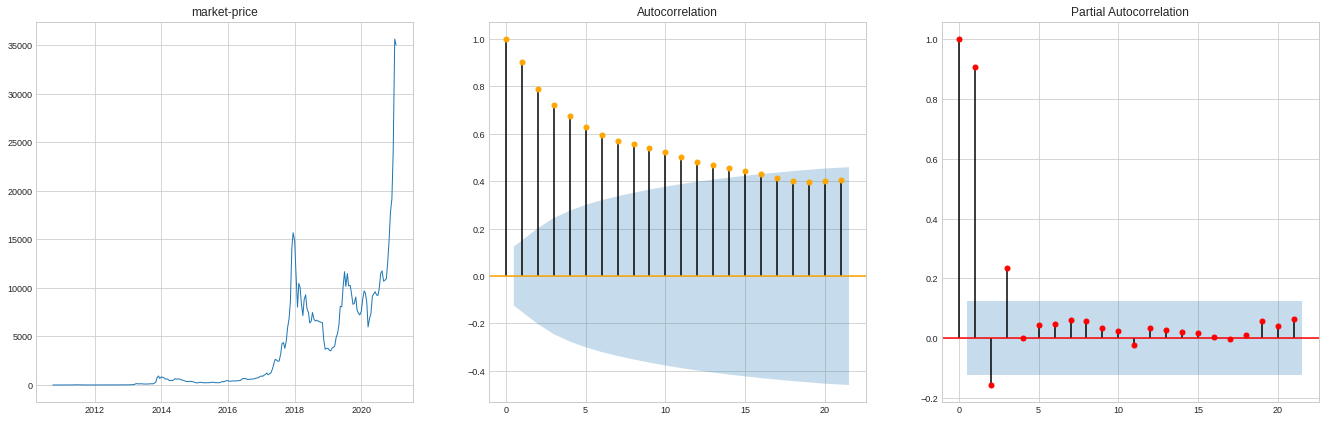

In [351]:
y = bitcoin["market-price"]

plt.rc('xtick',labelsize=9)
plt.rc('ytick',labelsize=9)

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))

axes[0].plot(y, linewidth=1); axes[0].set_title("market-price")
plot_acf(y, ax = axes[1], c="orange", lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

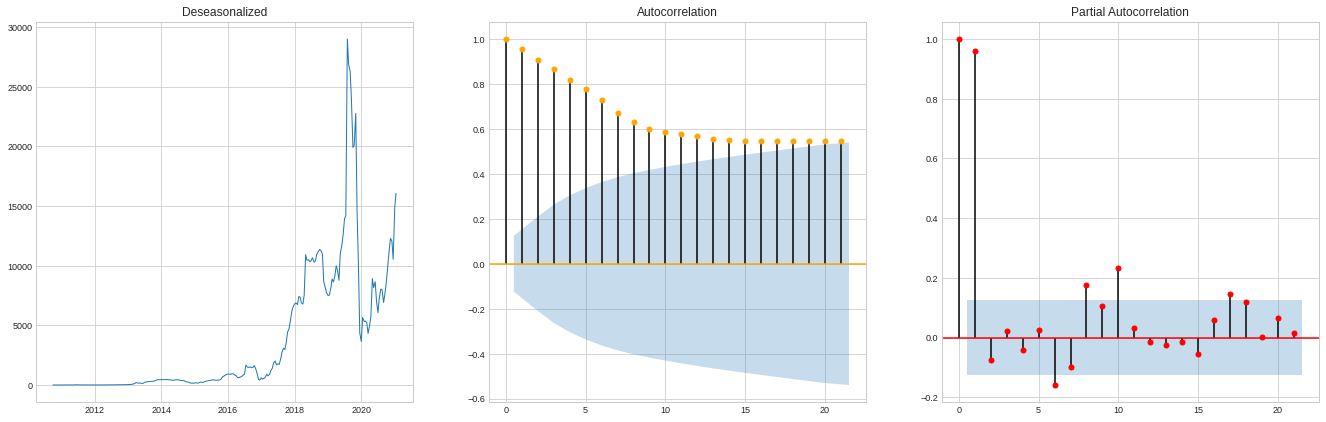

In [352]:
y = bitcoin["Deseasonalized"]

plt.rc('xtick',labelsize=9)
plt.rc('ytick',labelsize=9)

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))

axes[0].plot(y, linewidth=1); axes[0].set_title('Deseasonalized')
plot_acf(y, ax = axes[1], c="orange", lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

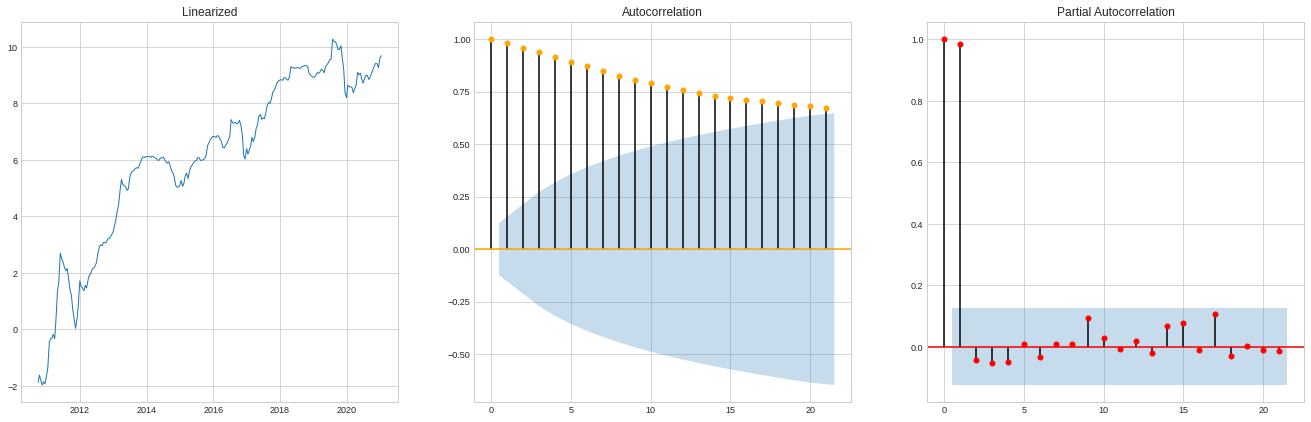

In [353]:
y = bitcoin["Linearized"]

plt.rc('xtick',labelsize=9)
plt.rc('ytick',labelsize=9)

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))

axes[0].plot(y, linewidth=1); axes[0].set_title('Linearized')
plot_acf(y, ax = axes[1], c="orange", lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

## STEP 2 | Seasonal differencing (D)

In [354]:
# bitcoin_train["Normal differencing"] = bitcoin_train["linearized"].diff(1)
# bitcoin_train["Seasonal differencing"] = bitcoin_train["linearized"].diff(12)
# bitcoin_train["Sesonal + Normal differencing"] = bitcoin_train["linearized"].diff(12).diff(1)

## STEP 3 | Differencing (d)

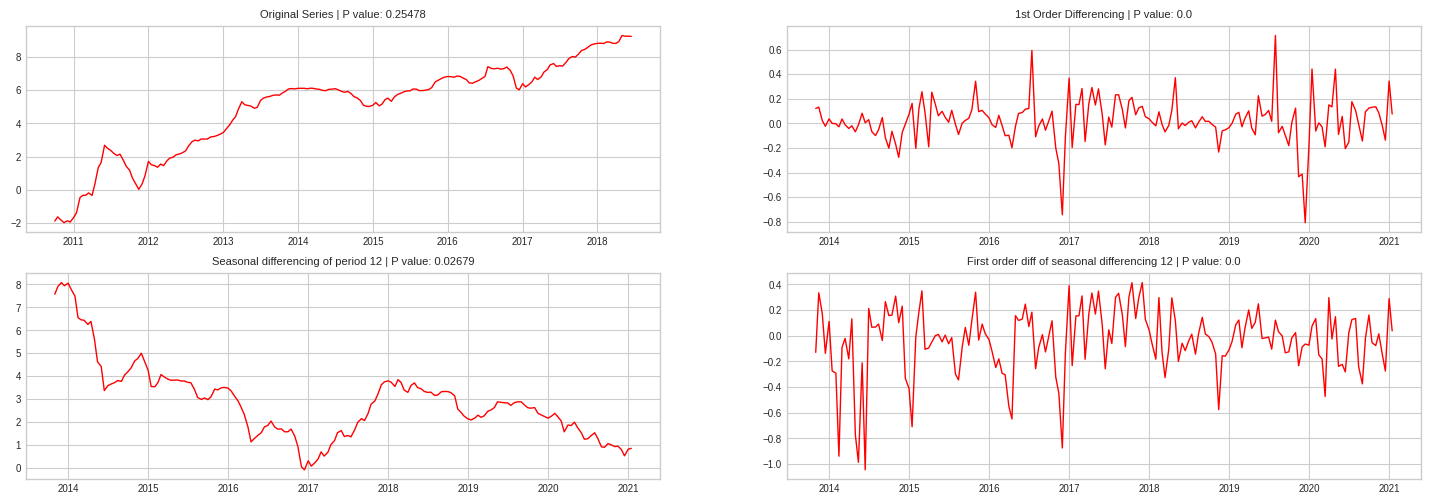

In [355]:
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)

fig, axs = plt.subplots(2, 2, figsize=(18,6), dpi = 100, facecolor = (STYLE), )

# Original series
axs[0,0].plot(bitcoin_train["Linearized"], linewidth=1, c = "r");
axs[0,0].set_title(f'Original Series | P value: {round(adfuller(bitcoin_train["Linearized"])[1], 5)}', fontsize= 8)

# Normal differencing
axs[0,1].plot(difference["Normal differencing"], linewidth=1, c = "r");
axs[0,1].set_title(f'1st Order Differencing | P value: {round(adfuller(difference["Normal differencing"].dropna())[1], 5)}', fontsize= 8)

# Seasonal differencing
axs[1,0].plot(difference["Seasonal differencing"], linewidth=1, c = "r");
axs[1,0].set_title(f'Seasonal differencing of period 12 | P value: {round(adfuller(difference["Seasonal differencing"].dropna())[1], 5)}', fontsize= 8)

# Sesonal + Normal differencing
axs[1,1].plot(difference["Sesonal + Normal differencing"], linewidth=1, c = "r");
axs[1,1].set_title(f'First order diff of seasonal differencing 12 | P value: {round(adfuller(difference["Sesonal + Normal differencing"].dropna())[1], 5)}', fontsize= 8);

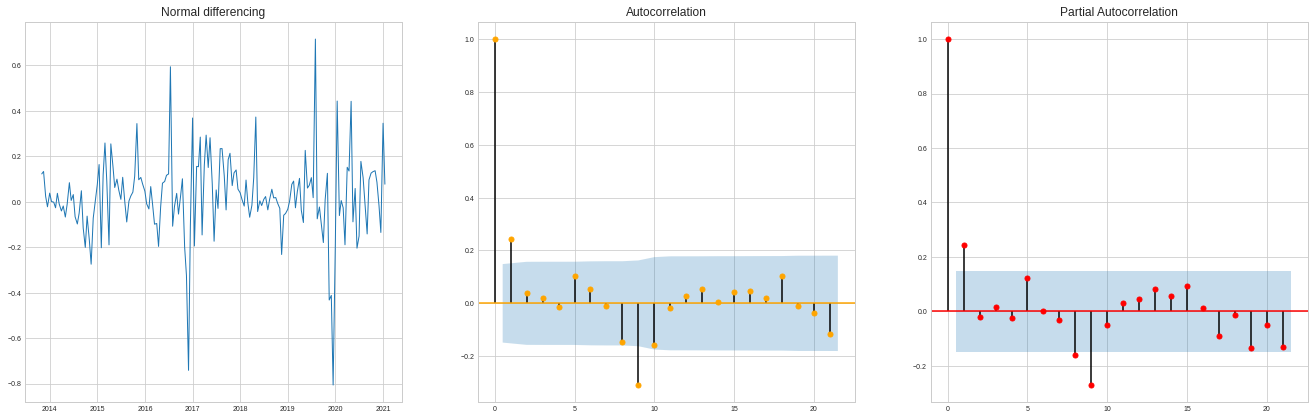

In [356]:
y = difference["Normal differencing"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Normal differencing')
plot_acf(y, ax = axes[1], c="orange", lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

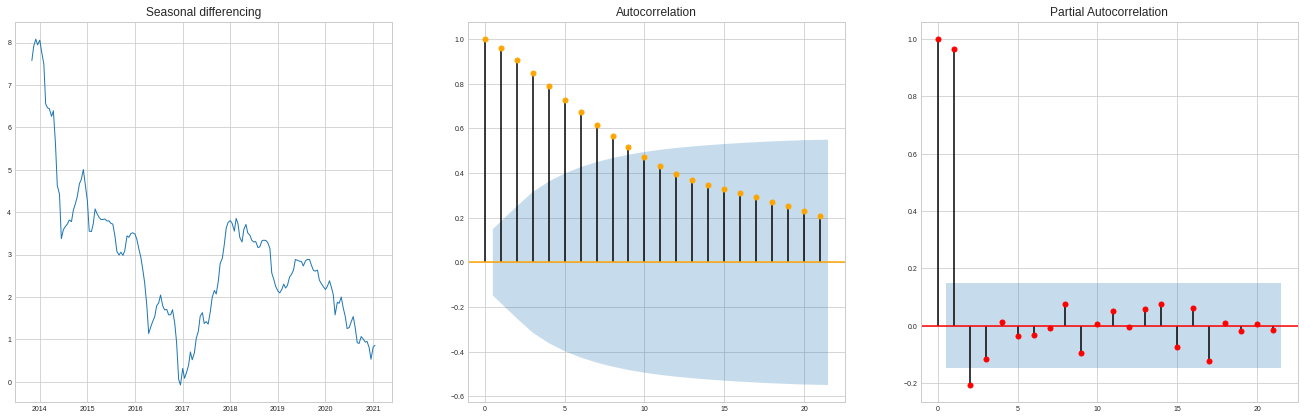

In [357]:
y = difference["Seasonal differencing"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Seasonal differencing')
plot_acf(y, ax = axes[1], c="orange", lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

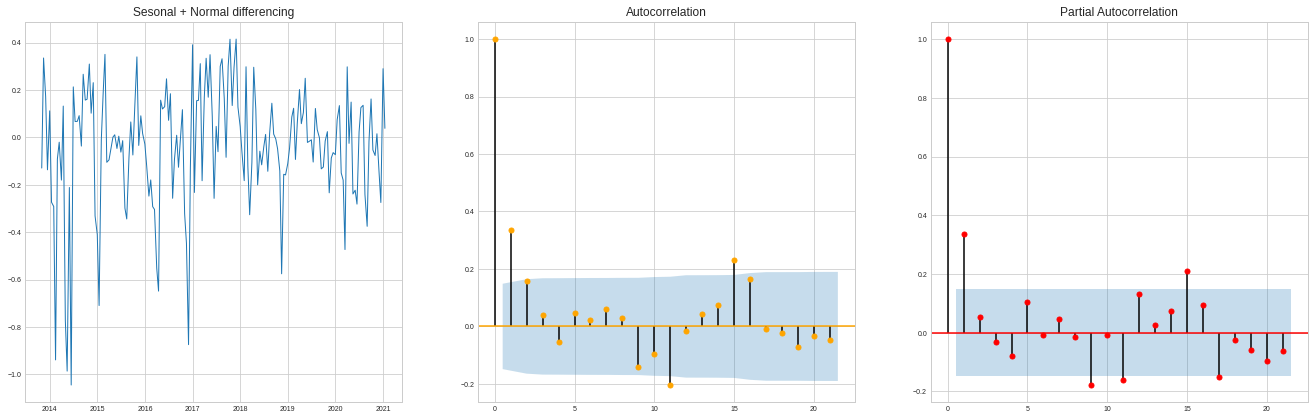

In [358]:
y = difference["Sesonal + Normal differencing"]

fig, axes = plt.subplots(1,3, figsize=(23, 7), facecolor = (STYLE))
axes[0].plot(y, linewidth=1); axes[0].set_title('Sesonal + Normal differencing')
plot_acf(y, ax = axes[1], c="orange", lags = FREQ * LAGS_BIAS);
plot_pacf(y, ax = axes[2], c='r', lags = FREQ * LAGS_BIAS);

## STEP 4 | Model and Hyperparameters

### Auto ARIMA

In [359]:
# The autocorrelation plot (plot_acf) applied to your fully differentiated series allows you to select MA number (q)
# MA( q ) = number of lag beyond which the  ACF  of  Y(d+D)  cuts off
# The partial autocorrelation plot plot_pacf applied to your fully differentiated series allows you to select AR (p)
# AR( p ) = number of lags beyond which the  PACF  of  Y(d+D)  cuts off

In [360]:
COLUMN = "Linearized"

In [361]:
smodel = pm.auto_arima(bitcoin_train[COLUMN],
                       # exogenous = bitcoin_train[["total-bitcoins"]],
                       test='adf',
                       seasonal=True,
                       d=None,
                       m = FREQ, # frequency of series. Important to choose manually
                       stepwise=True, # only check most interesting combination. False will take way longer
                       start_p=0, max_p=4,
                       start_d=0, max_d=4,
                       start_q=0, max_q=4,
                       start_P=0, max_P=4,
                       D=1,
                       start_Q=0, max_Q=4,
                       njobs=-1, trace=True, error_action='ignore', suppress_warnings=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[73]             : AIC=49.215, Time=1.49 sec
 ARIMA(1,1,0)(1,1,0)[73]             : AIC=33.291, Time=8.85 sec
 ARIMA(0,1,1)(0,1,1)[73]             : AIC=36.927, Time=17.20 sec
 ARIMA(1,1,0)(0,1,0)[73]             : AIC=34.340, Time=1.00 sec
 ARIMA(1,1,0)(2,1,0)[73]             : AIC=35.291, Time=24.31 sec
 ARIMA(1,1,0)(1,1,1)[73]             : AIC=35.291, Time=11.36 sec
 ARIMA(1,1,0)(0,1,1)[73]             : AIC=33.291, Time=6.89 sec
 ARIMA(1,1,0)(0,1,2)[73]             : AIC=35.291, Time=32.10 sec
 ARIMA(1,1,0)(1,1,2)[73]             : AIC=37.291, Time=41.92 sec
 ARIMA(0,1,0)(0,1,1)[73]             : AIC=49.937, Time=10.08 sec
 ARIMA(2,1,0)(0,1,1)[73]             : AIC=34.929, Time=11.95 sec
 ARIMA(1,1,1)(0,1,1)[73]             : AIC=35.004, Time=12.47 sec
 ARIMA(2,1,1)(0,1,1)[73]             : AIC=36.900, Time=23.16 sec
 ARIMA(1,1,0)(0,1,1)[73] intercept   : AIC=34.300, Time=12.21 sec

Best model:  ARIMA(1,1,0)(0,1,1)[73]

In [362]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  186
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 73)   Log Likelihood                 -13.645
Date:                              Fri, 29 Jan 2021   AIC                             33.291
Time:                                      19:52:17   BIC                             41.446
Sample:                                           0   HQIC                            36.599
                                              - 186                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3947      0.065      6.094      0.000       0.268       0.522
ma.S.L73      -0.2477      0.213     -1.160      0.246      -0.666       0.171
sigma2         0.0717      0.010      6.990      0.000       0.052       0.092
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                16.45
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.74
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

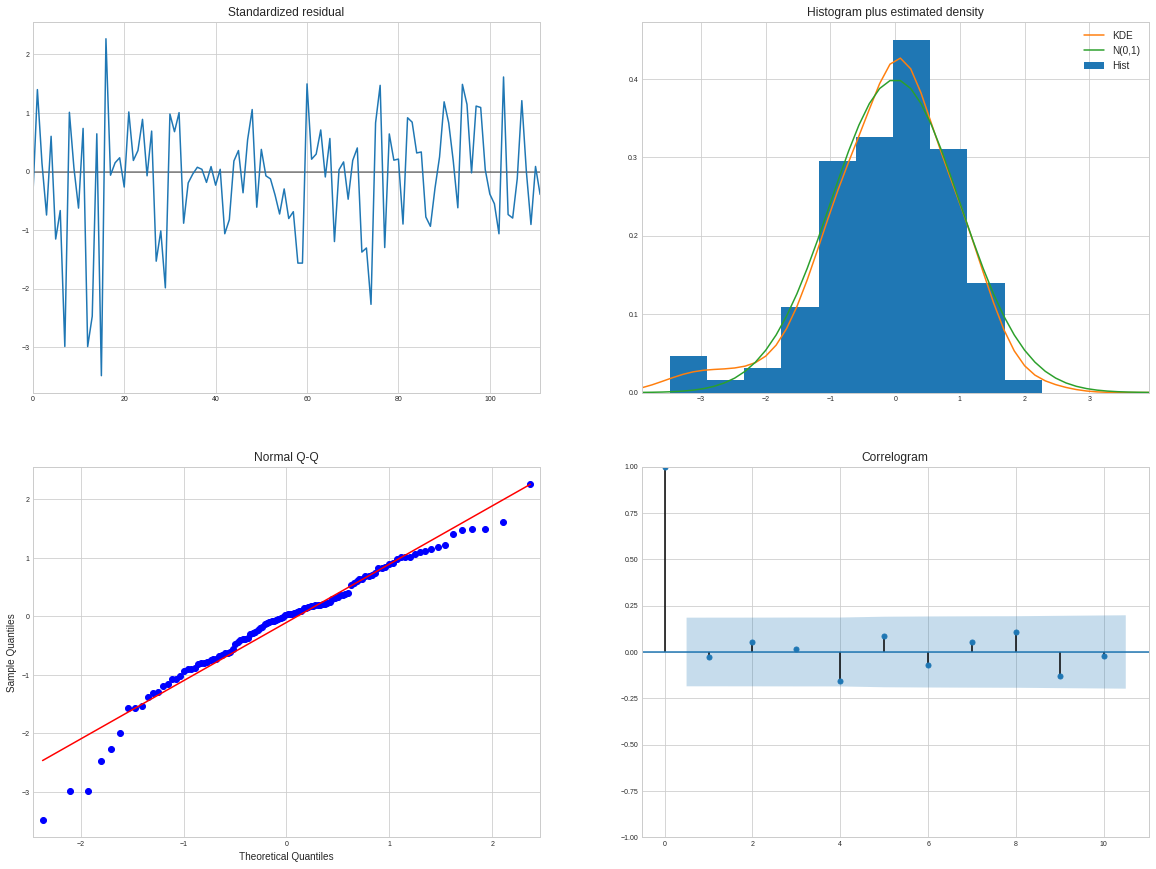

In [363]:
smodel.plot_diagnostics(figsize=(20,15))
plt.show()

In [364]:
# Forecast
n_periods = len(bitcoin_test[COLUMN]) # chequea cual es el largo del test set
fitted, confint = smodel.predict(n_periods = n_periods,
                                 # exogenous = np.tile(bitcoin_train["total-bitcoins"].values, 2).reshape(-1,1),
                                 return_conf_int = True) # Y lo pasa aca como el numero de periodos a predecir
index_y_test = bitcoin_test.index # pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted = pd.Series(fitted, index = index_y_test)
lower = pd.Series(confint[:, 0], index = index_y_test)
upper = pd.Series(confint[:, 1], index = index_y_test)

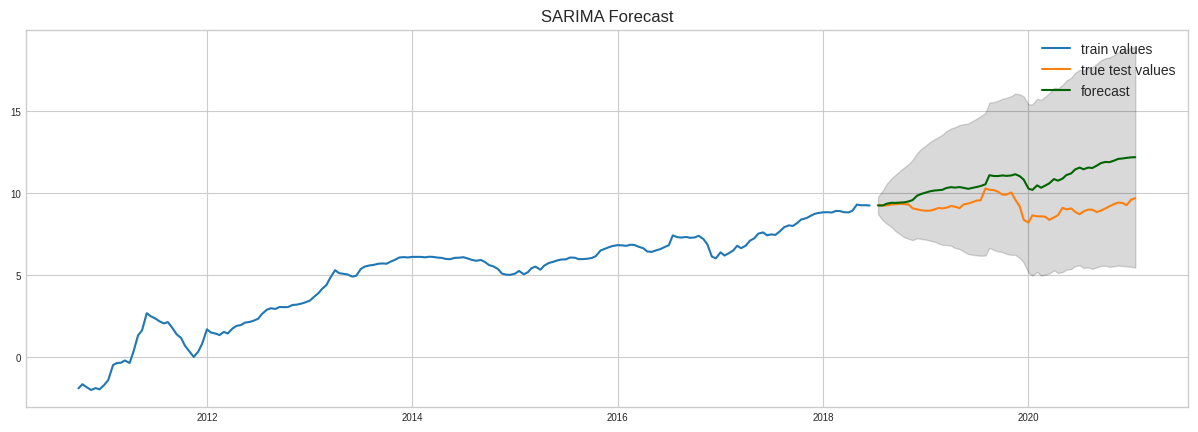

In [365]:
# Plot the linearized
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.plot(bitcoin_train[COLUMN], label = "train values")
plt.plot(bitcoin_test[COLUMN], label = "true test values")
plt.plot(fitted, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha = .15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [366]:
# re-compose back to initial time series

forecast_recompose = np.exp(fitted) * decomp_mult.seasonal[index + 1:]
train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
lower_recompose = np.exp(confint)[:,0] * decomp_mult.seasonal[index + 1:] # Confidence interval
upper_recompose = np.exp(confint)[:,1] * decomp_mult.seasonal[index + 1:]

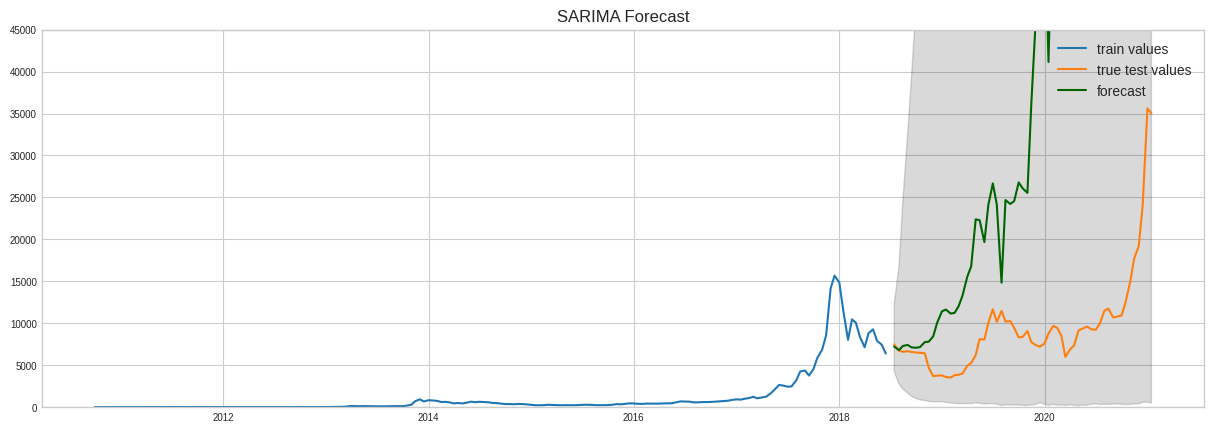

In [367]:
# Plot
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.ylim(0, 45000)
plt.plot(train_recompose, label = "train values")
plt.plot(test_recompose, label = "true test values")
plt.plot(forecast_recompose, color='darkgreen',label = "forecast")
plt.fill_between(lower_recompose.index, 
                 lower_recompose, 
                 upper_recompose, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

### SARIMA

In [368]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
# Build Model
sarima = SARIMAX(bitcoin_train[COLUMN],
                 order=(1, 1, 0), seasonal_order=(0,1,1,120), # SARIMA(p,d,q)(P,D,Q)[S] | BEST = (1,1,0)(0,0,1,63)
                 trend = [1]
                 )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(bitcoin_test), alpha = 0.05)
central = results.predicted_mean
confint = results.conf_int()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [369]:
# re-compose back to initial time series

forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:]
train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
lower_recompose = np.exp(confint[f"lower {COLUMN}"]) * decomp_mult.seasonal[index + 1:] # Confidence interval
upper_recompose = np.exp(confint[f"upper {COLUMN}"]) * decomp_mult.seasonal[index + 1:]


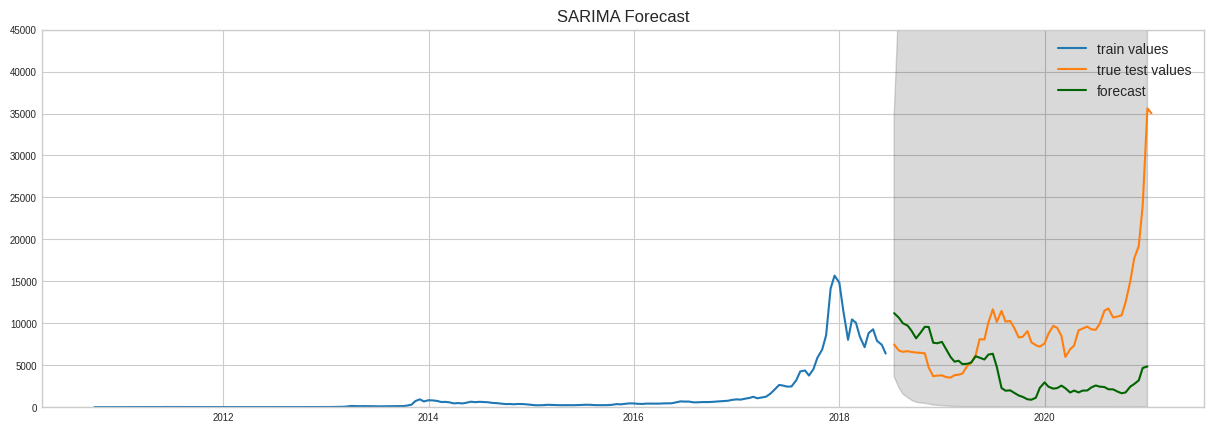

In [370]:
# Plot
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.ylim(0,45000)
plt.plot(train_recompose, label = "train values")
plt.plot(test_recompose, label = "true test values")
plt.plot(forecast_recompose, color='darkgreen',label = "forecast")
plt.fill_between(lower_recompose.index, 
                 lower_recompose, 
                 upper_recompose, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [371]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                            Linearized   No. Observations:                  186
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 120)   Log Likelihood                 -21.552
Date:                               Fri, 29 Jan 2021   AIC                             51.104
Time:                                       19:52:52   BIC                             59.801
Sample:                                   10-01-2010   HQIC                            54.536
                                        - 06-15-2018                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0348      0.051     -0.688      0.491      -0.134       0.064
ar.L1          0.3911      0.113      3.466      0.001       0.170       0.612
ma.S.L120  -2.584e-06   1.09e-08   -238.146      0.000   -2.61e-06   -2.56e-06
sigma2         0.1133      0.017      6.868      0.000       0.081       0.146
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.00
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+24. Standard errors may be unstable.
"""

### SARIMAX

In [372]:
exo = ["market-cap",	"trade-volume", "total-bitcoins" , "mvrv", "nvt", "nvts"]

sarimax = SARIMAX(endog=bitcoin_train[COLUMN],
        exog = bitcoin_train[exo],
        order = (1, 1, 0), seasonal_order = (0,1,0,123), # SARIMA(p,d,q)(P,D,Q)[S] | BEST = (1,1,0)(0,0,1,63)
        trend = [1],
        # trend_offset = 1,
        time_varying_regression = False,
        mle_regression = True
       )

sarimax = sarimax.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [373]:
# Forecast
results = sarimax.get_forecast(len(bitcoin_test), exog = bitcoin_test[exo], dynamic= True, alpha=0.5)
central = results.predicted_mean
confint = results.conf_int()

In [374]:
# re-compose back to initial time series

forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:]
train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
lower_recompose = np.exp(confint[f"lower {COLUMN}"]) * decomp_mult.seasonal[index + 1:] # Confidence interval
upper_recompose = np.exp(confint[f"upper {COLUMN}"]) * decomp_mult.seasonal[index + 1:]

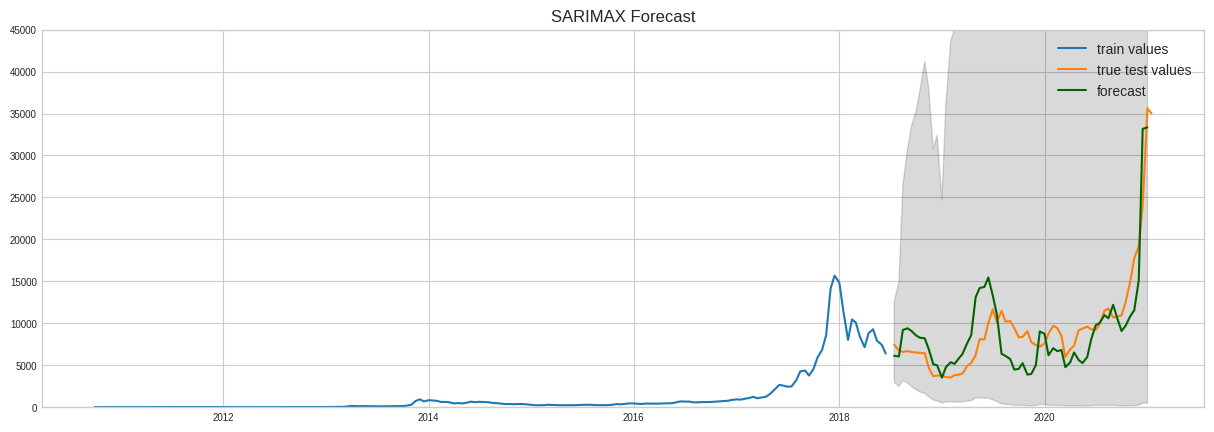

In [375]:
# Plot
plt.figure(figsize=(15,5), dpi=100, facecolor = (STYLE))
plt.ylim(0,45000)
plt.plot(train_recompose, label = "train values")
plt.plot(test_recompose, label = "true test values")
plt.plot(forecast_recompose, color='darkgreen',label = "forecast")
plt.fill_between(lower_recompose.index, 
                 lower_recompose, 
                 upper_recompose, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast")
plt.legend()
plt.show()

In [376]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Linearized   No. Observations:                  186
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 123)   Log Likelihood                  -0.034
Date:                             Fri, 29 Jan 2021   AIC                             18.068
Time:                                     19:53:12   BIC                             37.213
Sample:                                 10-01-2010   HQIC                            25.585
                                      - 06-15-2018                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0023   5.73e-12  -4.02e+08      0.000      -0.002      -0.002
market-cap      4.361e-13   3.16e-12      0.138      0.890   -5.76e-12    6.63e-12
trade-volume   -5.535e-12   2.86e-10     -0.019      0.985   -5.67e-10    5.56e-10
total-bitcoins  9.132e-07   4.28e-07      2.132      0.033    7.38e-08    1.75e-06
mvrv               0.2791   5.71e-13   4.89e+11      0.000       0.279       0.279
nvt               -0.0067   2.58e-11  -2.58e+08      0.000      -0.007      -0.007
nvts              -0.0047    7.2e-12  -6.54e+08      0.000      -0.005      -0.005
ar.L1              0.1252   1.97e-13   6.35e+11      0.000       0.125       0.125
sigma2             0.0595   2.29e-12    2.6e+10      0.000       0.060       0.060
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.88
Prob(Q):                              0.97   Prob(JB):                         0.05
Heteroskedasticity (H):               0.42   Skew:                             0.30
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.24e+29. Standard errors may be unstable.
"""

In [377]:
raise SystemExit("Stop right there!")

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# PRUEBAS

In [ ]:
# # Plot mas a futuro

# central, confint = smodel.predict(n_periods = n_periods + 100, return_conf_int = True)

# dti = pd.date_range(bitcoin_test.index.values[0], periods = n_periods + 100, freq = RESAMPLE)

# central = pd.Series(central, index = dti)

# # re-compose back to initial time series

# forecast_recompose = np.exp(central) * decomp_mult.seasonal[index + 1:] # los valores nan me llevan la multiplicacion a nada
# train_recompose = np.exp(bitcoin_train[COLUMN]) * decomp_mult.seasonal[0:index + 1]
# test_recompose = np.exp(bitcoin_test[COLUMN]) * decomp_mult.seasonal[index + 1:]
# lower_recompose = np.exp(confint)[:,0] * decomp_mult.seasonal[index + 1:] # Confidence interval
# upper_recompose = np.exp(confint)[:,1] * decomp_mult.seasonal[index + 1:]

# plt.figure(figsize=(15,5), dpi=100, facecolor = ("#383838"))

# plt.plot(train_recompose, label = "train values")
# plt.plot(test_recompose, label = "true test values")
# plt.plot(forecast_recompose, color='darkgreen',label = "forecast")

# plt.legend()
# plt.show()

In [ ]:
# # Forecast
# n_periods = 24
# fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
# index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

In [ ]:
# str(list(np.arange(6,160,6)))

In [ ]:
# for f in [6, 12, 18, 24, 30, 36]:
#   pmodel = pm.auto_arima(bitcoin_train[COLUMN],
#                         seasonal=True,
#                         m = f, # frequency of series. Important to choose manually
#                         stepwise=True, # only check most interesting combination. False will take way longer
#                         start_p=0, max_p=3,
#                         start_d=0, max_d=3,
#                         start_q=0, max_q=3,
#                         start_P=0, max_P=3,
#                         start_D=0, max_D=3,
#                         start_Q=0, max_Q=3,
#                         njobs=-1, trace=True, error_action='ignore', suppress_warnings=True)

# print(pmodel.summary())

In [ ]:
# # Forecast
# n_periods = len(bitcoin_test[COLUMN]) # chequea cual es el largo del test set
# central, confint = pmodel.predict(n_periods = n_periods, return_conf_int = True) # Y lo pasa aca como el numero de periodos a predecir
# index_y_test = bitcoin_test.index # pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# # make series for plotting purpose
# central = pd.Series(central, index = index_y_test)
# lower = pd.Series(confint[:, 0], index = index_y_test)
# upper = pd.Series(confint[:, 1], index = index_y_test)

In [ ]:
# # Plot
# plt.figure(figsize=(15,5), dpi=100, facecolor = ("#383838"))
# plt.plot(bitcoin_train[COLUMN], label = "train values")
# plt.plot(bitcoin_test[COLUMN], label = "true test values")
# plt.plot(central, color='darkgreen',label = "forecast")
# plt.fill_between(lower.index, 
#                  lower, 
#                  upper, 
#                  color='k', alpha=.15)

# plt.title("SARIMA Forecast")
# plt.legend()
# plt.show()